In [2]:
import time
import numpy as np
import pandas as pd
import survtreeshap as sts
import utils

import matplotlib.pyplot as plt
from sksurv.datasets import load_whas500
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from survshap import SurvivalModelExplainer, PredictSurvSHAP

from sksurv.util import Surv

from sklearn.datasets import make_classification
from sksurv.metrics import integrated_brier_score
from sksurv.metrics import concordance_index_censored


from lifelines.utils import concordance_index

/home/ducrot/miniconda3/envs/env_survtreeshap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data simulation with Cox model

In [3]:

betas = [6,4,2, 1, 0.5, 0.1]

df = utils.simulate_cox_data_with_custom_betas(
    n=1000,
    betas=betas,
    censoring_rate=0.4,
    seed=42
)

df.head()


,X1,X2,X3,X4,X5,X6,time,event
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,6.607138e+00,True
1,1.579213,0.767435,-0.469474,0.542560,-0.463418,-0.465730,1.087627e-02,True
2,0.241962,-1.913280,-1.724918,-0.562288,-1.012831,0.314247,5.090507e+07,True
3,-0.908024,-1.412304,1.465649,-0.225776,0.067528,-1.424748,8.464227e+06,True
4,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,1.657051e+04,True


# Random survival forest on simulated data

In [4]:
#Creation of X,y : X covariates and y survival data
X = df.drop(columns=['time', 'event']).values
X = pd.DataFrame(X, columns=[f"cov_{i}" for i in range(X.shape[1])])
y = np.array(list(zip(df['event'].astype(bool), df['time'])),dtype=[('event', '?'), ('time', 'f8')])

In [5]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
#RSF training
rsf = RandomSurvivalForest(n_estimators=100, random_state=42, max_depth=10, max_leaf_nodes=20).fit(X_train, y_train)

In [7]:
#C-index 
y_pred = rsf.predict(X_test)
c_index_rsf = concordance_index_censored(y_test["event"], y_test["time"], y_pred)[0]
c_index_rsf
print(f"C-index RSF:    {c_index_rsf:.3f}")

#Integrated Brier Score (useless alone)
times_ibs = np.percentile(y["time"], np.linspace(10, 90, 100))
rsf_surv_funcs = rsf.predict_survival_function(X_test)
rsf_surv_preds = np.vstack([fn(times_ibs) for fn in rsf_surv_funcs])
ibs_rsf = integrated_brier_score(y_train, y_test, rsf_surv_preds, times_ibs)
print(f"Integrated Brier Score RSF:   {ibs_rsf:.3f}")

C-index RSF:    0.882
Integrated Brier Score RSF:   0.072


# Explainations from SurvTreeSHAP

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:01<00:00, 565.57it/s]


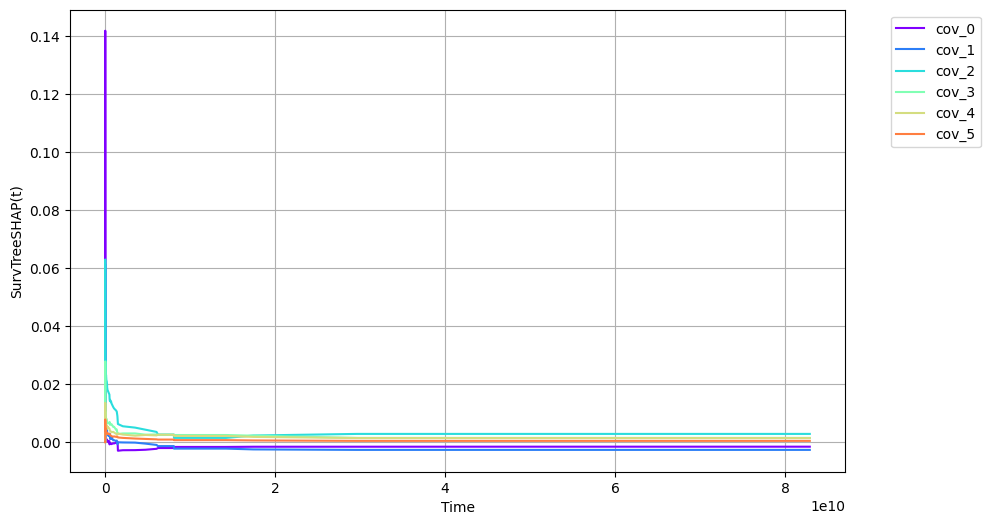

In [8]:
#creation of the explainer
explainer=sts.SurvTreeSHAPexplainer(rsf, X_test)

#Explaination across time points for a single individual
explainer.plotgraph(n=12)

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [04:02<00:00,  1.21s/it]


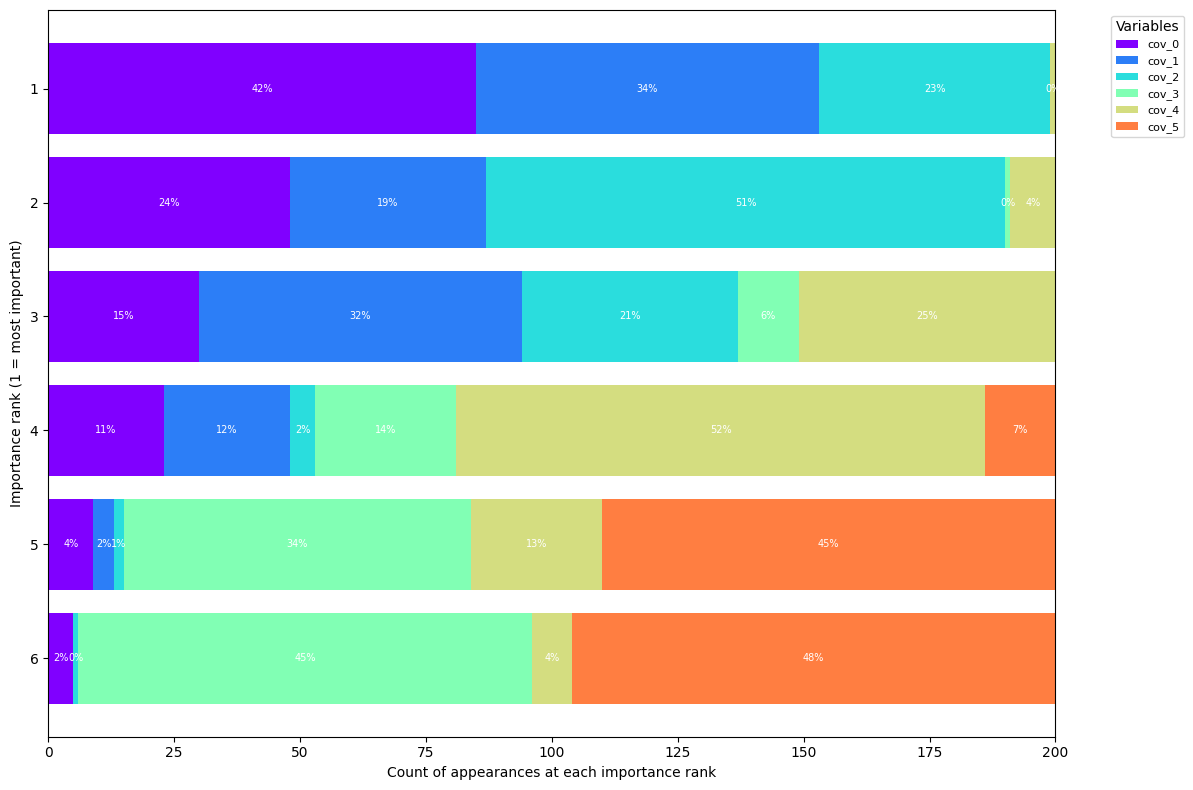

Execution time: 242.89 seconds


In [10]:
#Ranking aggragtion of SurvTreeSHAP(t) values over "nb_toexplain" individuals
nb_toexplain=200
explainer.rankvariables(nb_toexplain)

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [04:04<00:00,  1.22s/it]


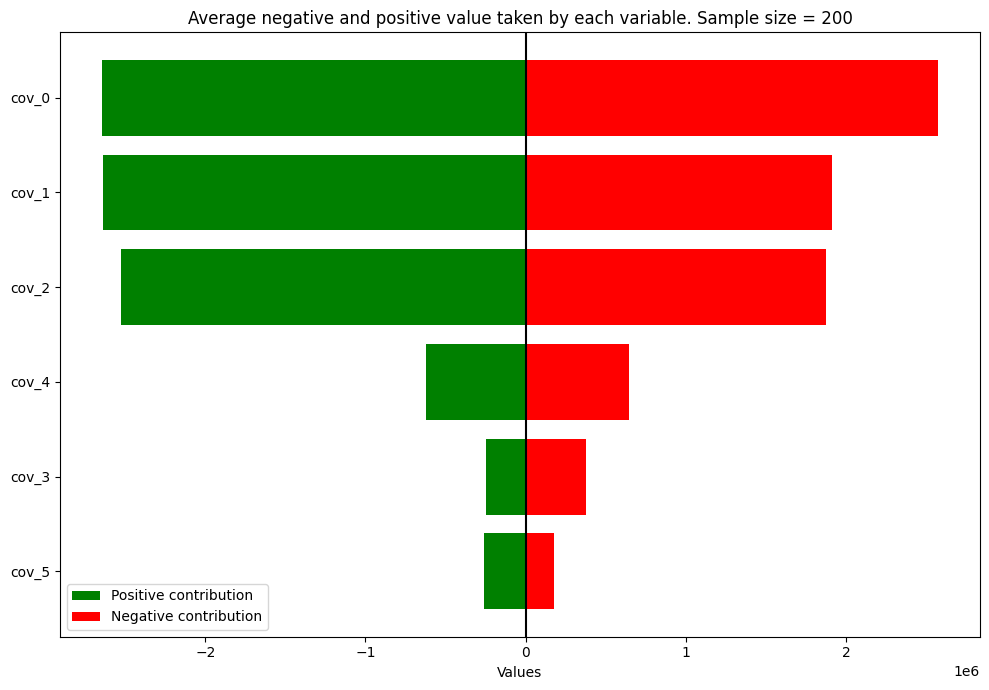

In [11]:
nb_toexplain=200
explainer.averagesurvshap(nb_toexplain)
